Imports

In [6]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, learning_curve
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.optimizers import Nadam

Global Variables

In [20]:
INPUT_FILE = 'dataset-HAR-PUC-Rio.csv'
DELIM = ';'

HIDDEN_LAYER_NODES = 22
OUT_NODES = 5

LEARNING_RATE = 0.1
MOMENTUM = 0.6

EPOCHS = 200
BATCH_SIZE = 32

Basic Functions

In [7]:
def underSample(df): # underSamples our dataset
    class_1 = df[df['class'] == 1]
    class_2 = df[df['class'] == 2]
    class_3 = df[df['class'] == 3]
    class_4 = df[df['class'] == 4]
    class_5 = df[df['class'] == 5]

    def getMinimunNumber(numbers):
        return min(numbers)
    
    # min_count = getMinimunNumber([class_1['class'].count(), class_2['class'].count(
    # ), class_3['class'].count(), class_4['class'].count(), class_5['class'].count()])
    min_count = 20
    # pick random samples from classes 1 - 5 (cause there is a big difference between them)
    class_1 = class_1.sample(min_count)
    class_2 = class_2.sample(min_count)
    class_3 = class_3.sample(min_count)
    class_4 = class_4.sample(min_count)
    class_5 = class_5.sample(min_count)

    return_df = pd.concat(
        [class_1, class_2, class_3, class_4, class_5], ignore_index=True)

    return return_df


def import_from_csv_and_change_values():
    imported_df = pd.read_csv(
        INPUT_FILE, delimiter=DELIM, low_memory=False)
    # --------------------------------------------
    # Woman = 1
    # Man = 2
    # x values = [-617,533]
    #
    # class values will be transformed to (1,2,3,4,5)
    # sittingdown = 1
    # standingup = 2
    # standing = 3
    # walking = 4
    # sitting = 5
    # --------------------------------------------
    imported_df.replace({'gender': {"Woman": 1, "Man": 2}}, inplace=True)
    imported_df.replace({'class': {
        "sittingdown": 1,
        "standingup": 2,
        "standing": 3,
        "walking": 4,
        "sitting": 5
    }}, inplace=True)
    imported_df.replace(',', '.', inplace=True, regex=True)

    imported_df['how_tall_in_meters'] = imported_df['how_tall_in_meters'].astype(
        float)
    imported_df['body_mass_index'] = imported_df['body_mass_index'].astype(
        float)

    # remove unnecessary data from dataframe
    imported_df = imported_df.drop('user', axis='columns')
    imported_df = underSample(imported_df)
    return imported_df


Baseline Model

In [8]:
def baseline_model():
    hidden_layer_nodes = 11
    out_nodes = 5

    # create model
    model = Sequential()

    model.add(Dense(hidden_layer_nodes, input_dim=17, activation='relu'))
    model.add(Dense(out_nodes, input_dim=hidden_layer_nodes, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=Nadam(
        learning_rate=LEARNING_RATE, use_ema=True, ema_momentum=MOMENTUM), metrics=['accuracy'])
    return model

Main Function

In [21]:
start_dataframe = import_from_csv_and_change_values()
print("Data reached and ready!")

start_dataset = start_dataframe.to_numpy()

X = start_dataset[:, :-1]
y = start_dataset[:, -1]

X_transformed = QuantileTransformer().fit_transform(X)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
print("Y converted to categorical variables!")

estimator = KerasClassifier(build_fn=baseline_model, verbose=0)
print("Estimator made")
batch_sizes = [2, 8, 10, 16, 32, 64, 80, 100]
epochs = [10, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200]

kFold = KFold(n_splits=5, shuffle=True)

print("Making Learning Curve...")

train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, dummy_y, cv=kFold, n_jobs=-1)

train_sizes = np.linspace(0.1, 1.0, 5),

#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Data reached and ready!
Y converted to categorical variables!
Estimator made
Making Learning Curve...


E:\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (100). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\BranlessPOMO\AppData\Local\Temp\ipykernel_7904\1079432312.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, verbose=0)


Plot Learning Curve

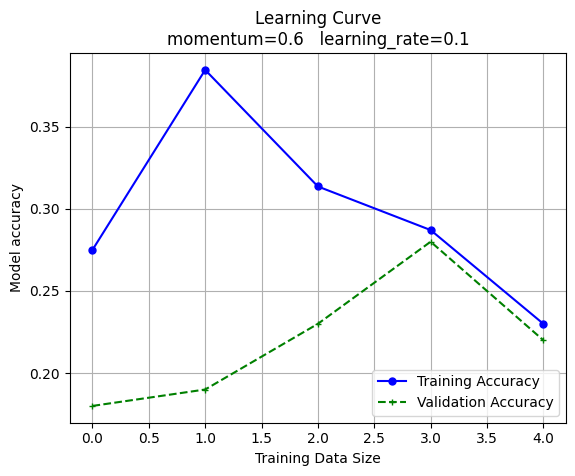

In [22]:
plt.plot(train_mean, color='blue', marker='o',
         markersize=5, label='Training Accuracy')
plt.plot(test_mean, color='green', marker='+',
         markersize=5, linestyle='--', label='Validation Accuracy')
plt.title(f'Learning Curve\nmomentum={MOMENTUM}   learning_rate={LEARNING_RATE}')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()